In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OSNLP.csv',encoding="ISO-8859-1")
X

,iD,Response,Reviewer-1,Reviewer-2,word choice,Organization
0,1,An operating system (OS) is system software th...,4,4,3.0,1.0
1,1,An operating system is the most important soft...,5,5,2.0,3.0
2,1,Collection of programs that manages hardware r...,2,1,1.0,1.0
3,1,It is an interface user and machine(hardware),2,1,1.0,0.0
4,1,An operating system is a software which acts a...,3,2,2.0,1.0
...,...,...,...,...,...,...
2385,5,Single processor contains only one processer.w...,2,2,NaN,NaN
2386,5,Single processor systems are less reliable tha...,3,3,NaN,NaN
2387,5,Single processor system contains only one proc...,2,2,NaN,NaN
2388,5,Single processor can assign only one task but ...,1,1,NaN,NaN


In [ ]:
y = X.iloc[:,3:6]
X = X.dropna(axis=1)

print(y)

      Reviewer-2  word choice  Organization
0              4          3.0           1.0
1              5          2.0           3.0
2              1          1.0           1.0
3              1          1.0           0.0
4              2          2.0           1.0
...          ...          ...           ...
2385           2          NaN           NaN
2386           3          NaN           NaN
2387           2          NaN           NaN
2388           1          NaN           NaN
2389           2          NaN           NaN

[2390 rows x 3 columns]


In [ ]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300,dropout=0.5,recurrent_dropout=0.4, input_shape=[1, 2944], return_sequences=True))
    #model.add(LSTM(300, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(200, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(lr=0.001),metrics=['accuracy'])
    #model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
import tensorflow_hub as hub

use = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
aa=[]

In [ ]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    #tokennizer=PunktSentenceTokenizer(english.pickle)
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append((raw_sentence))
    #print(sentences)
    return sentences

def makeFeatureVec(words, num_features,n):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((n,num_features),dtype="float32")
    #success
    x=use(words) #length of feature vector is (16,512) and length of use is (16,128)
    y=len(x[0])
#     featureVec = np.zeros((n,num_features),dtype="float32")
    featureVec = np.zeros((n,y),dtype="float32")
    featureVec = np.add(featureVec,x).flatten() # getting error while adding vectors
    ss=num_features-y
#     print("diff=",ss)
    featureVec = np.pad(featureVec, (0,ss), 'constant', constant_values=(0, 0))
#     print("AFTER PADDING",featureVec,len(featureVec))
#     print("SHAPE",featureVec.shape)     
    #featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, num_features,aa):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features*23),dtype="float32") # creating max length feature vector having 0s
#     print(num_features*96)
    for essay in essays:
        
#         #essayFeatureVecs.insert(counter,makeFeatureVec(essay,num_features,aa[counter]))
        arr=makeFeatureVec(essay, num_features,aa[counter]).flatten() # getting error here
#         print(arr)
        ss=(num_features*23)-len(arr)
        arr1=np.pad(arr,(0,ss),'constant', constant_values=(0, 0))
#         #print(np.add(arr1,np.zeros(num_features*np.max(aa))))
        essayFeatureVecs[counter] = np.add(arr1,np.zeros((num_features*23),dtype="float"))
#         #makeFeatureVec(essay, num_features,aa[counter]).flatten()
#         #print(essayFeatureVecs[0])
        counter = counter + 1
    return essayFeatureVecs

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf

cv = KFold(n_splits = 5, shuffle = True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    #print(X_train.isna())
    train_essays = X_train['Response']
    test_essays = X_test['Response']
    y_train=y_train
    y_test=y_test
    num_features = 128
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3
    clean_train_essays = []
    clean_test_essays=[]
    #essays=train_essays
    sentences=[]
    l1=[]
    l2=[]
    for essay in train_essays:
      sentences += essay_to_sentences(essay, remove_stopwords = False)
  
      #print(sentences)
    for essay in test_essays:
      sentences += essay_to_sentences(essay, remove_stopwords = False)

    for essay_v in train_essays:
      l1.append(len(sent_tokenize(essay_v)))
      clean_train_essays.append(essay_to_sentences(essay_v, remove_stopwords=True))
      #print(clean_train_essays)
    a=np.array(l1)
    print(np.max(a))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, num_features,a)
    for essay_v in test_essays:
      l2.append(len(sent_tokenize(essay_v)))
      clean_test_essays.append(essay_to_sentences(essay_v, remove_stopwords=True))
    b=np.array(l2)
    testDataVecs=getAvgFeatureVecs(clean_test_essays, num_features,b)
    trainDataVecs=np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    trainDataVecs=np.reshape(trainDataVecs,(trainDataVecs.shape[0],1,trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    print(b)
    #print(y_train)
    X_train, X_val, y_train, y_val = train_test_split(trainDataVecs, y_train, test_size=0.2, random_state=3)
    lstm_model = get_model()
    history=lstm_model.fit(X_train, y_train, batch_size=16, epochs=50,validation_data=(X_val, y_val))
    
    #history=lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=30)
    y_pred=(lstm_model.predict(testDataVecs))
    #print(testDataVecs)
    # Save any one of the 5 models.
    if count == 6:
      break
         #lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    #print(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    
    count += 1


--------Fold 1--------

23


[ 4  1  1  1  1  2  1  1  2  3  1  1  1  2  2  2  1  1  7  2  2  1  1  1
  1  4  1  1  1  1  1  1  4  2  1  3  6  4  4  1  2  1  1  1  1  1  1  1
  1  1  4  1  1  1  1  1  2  1  1  5  2  3  1  1  1  1  3  1  1  1  1  4
  2  2  1  1  1  1  4  1  1  1  1  1  4  2  1  1  3  1  1  1  5  1  2  2
  1  1  1  1  1  1  1  3  1  1  2  2  2  1  1  1  1 10  1  4  7  1  1  1
  9  5  9  7  1  1  2  1  2  1  1  2  2  1  9  3  8  1  2  5  1 10  9  1
  9  1  1  3  6  4  3  3  4  6  2  2  7  1  5  7  2  1  1  1  1  8  1  1
  1  1  1  5  1  5  1  1  1  1  1  2  4  1  3  1  1  2  1  2  5  6  1  5
  1  1  3  3  7  1  1  1  1  1  6  4  1  2  1  2  5  2  5  5  1  2  2  1
  2  1  1  3  1  1  1  1  2  1  1  1  1  1  1  2  1  2  1  1  7  1  1  1
  1 16  1  2  2  1  1 12  2  2  2  1  4  3  1  1  8  1  3  1  1  1  2  3
  1  1  1  3  1  2  1  1  1  9  3  1  4  2  7  2  3  1  1  1  1  1  2  1
  3  1  2  1  3  1  1  2  2  1  1  1  2  1  2  2  1  1  1  5  2  1  1  2
  1  7  4  3  2  2  1  2  1  2  2  1  2  1  2  6  1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 300)            3894000   
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            400800    
                                                                 
 lstm_2 (LSTM)               (None, 1, 100)            120400    
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 4,457,635
Trainable params: 4,457,635
Non-

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
96/96 [==============================] - 16s 34ms/step - loss: nan - accuracy: 0.9529 - val_loss: nan - val_accuracy: 0.9765
Epoch 2/50
96/96 [==============================] - 2s 23ms/step - loss: nan - accuracy: 0.9588 - val_loss: nan - val_accuracy: 0.9765
Epoch 3/50
96/96 [==============================] - 2s 24ms/step - loss: nan - accuracy: 0.9588 - val_loss: nan - val_accuracy: 0.9765
Epoch 4/50
96/96 [==============================] - 3s 35ms/step - loss: nan - accuracy: 0.9588 - val_loss: nan - val_accuracy: 0.9765
Epoch 5/50
96/96 [==============================] - 2s 24ms/step - loss: nan - accuracy: 0.9588 - val_loss: nan - val_accuracy: 0.9765
Epoch 6/50
96/96 [==============================] - 2s 23ms/step - loss: nan - accuracy: 0.9588 - val_loss: nan - val_accuracy: 0.9765
Epoch 7/50
96/96 [==============================] - 2s 23ms/step - loss: nan - accuracy: 0.9588 - val_loss: nan - val_accuracy: 0.9765
Epoch 8/50
96/96 [==============================] - 2s

ValueError: ignored

In [ ]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=3))

Average Kappa score after a 5-fold cross validation:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


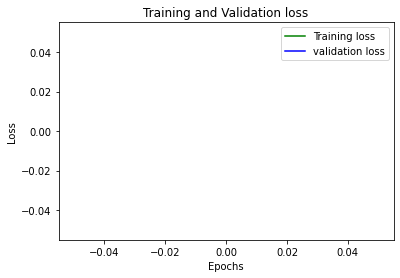

In [ ]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(y_test)
import matplotlib.pyplot as plt
x=np.arange(0,62)
plt.title("actual vs predicted score")
plt.xlabel("essays")
plt.ylabel("score")

plt.scatter(x,y_test.values,color='r',label="actual score")
plt.scatter(x,y_pred,color='b',label="predicted score")
plt.tight_layout()
plt.show()
